# Insolation Stack

This notebook reproduces the figure that shows our non-detrended speleothem oxygen isotope data plotted against local insolation. We use our Bchron age models here.

In [1]:
import pickle

import pyleoclim as pyleo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.transforms as transforms

from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from climlab.solar.orbital import OrbitalTable
from climlab.solar.insolation import daily_insolation

Tokenization took: 1.30 ms
Type conversion took: 0.76 ms
Parser memory cleanup took: 0.00 ms


/Users/alexjames/miniconda3/envs/docs/lib/python3.10/site-packages/climlab/convection/akmaev_adjustment.py:142: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  Akmaev_adjustment = jit(signature_or_function=Akmaev_adjustment)


In [2]:
with open('../data/series_dict.pkl','rb') as handle:
    series_dict = pickle.load(handle)

with open('../data/ens_dict.pkl','rb') as handle:
    ens_dict = pickle.load(handle)

with open('../data/pos_dict.pkl','rb') as handle:
    pos_dict = pickle.load(handle)

In [3]:
with open('../data/oman_ens.pkl','wb') as handle:
    pickle.dump(ens_dict['Oman'],handle)

In [4]:
lat_dict = {series.lat:series.label for series in series_dict.values()}

sort_index = np.sort(np.array(list(lat_dict.keys())))[::-1]
sort_label = [lat_dict[lat] for lat in sort_index]
series_dict = {label:series_dict[label] for label in sort_label} #Sort by latitude
ens_dict = {label:ens_dict[label] for label in sort_label} #Sort by latitude

Loading local insolation, using the boreal summer solstice as our date.

In [5]:
inso_dict = {}
# array with specified kyears (can be plain numpy or xarray.DataArray)
years = np.arange(-1000, 0)

# subset of orbital parameters for specified time
orb = OrbitalTable.interp(kyear=years)

#Day numbers from June 1st to August 31st
june21 = 172

for label,pos in pos_dict.items():
    lat = pos['lat']
    inso = daily_insolation(lat=lat, day=june21, orb=orb)
    inso_series = pyleo.Series(time=0-years[::-1],value=inso[::-1],time_name='Age',time_unit='Kyr BP',value_name=f'JJA Insolation {lat} N',value_unit='W/m^2',verbose=False).convert_time_unit('Years BP')
    inso_dict[label] = inso_series

In [6]:
with open('../data/holo_chrons_combined.pkl','rb') as handle:
    holo_chrons = pickle.load(handle)

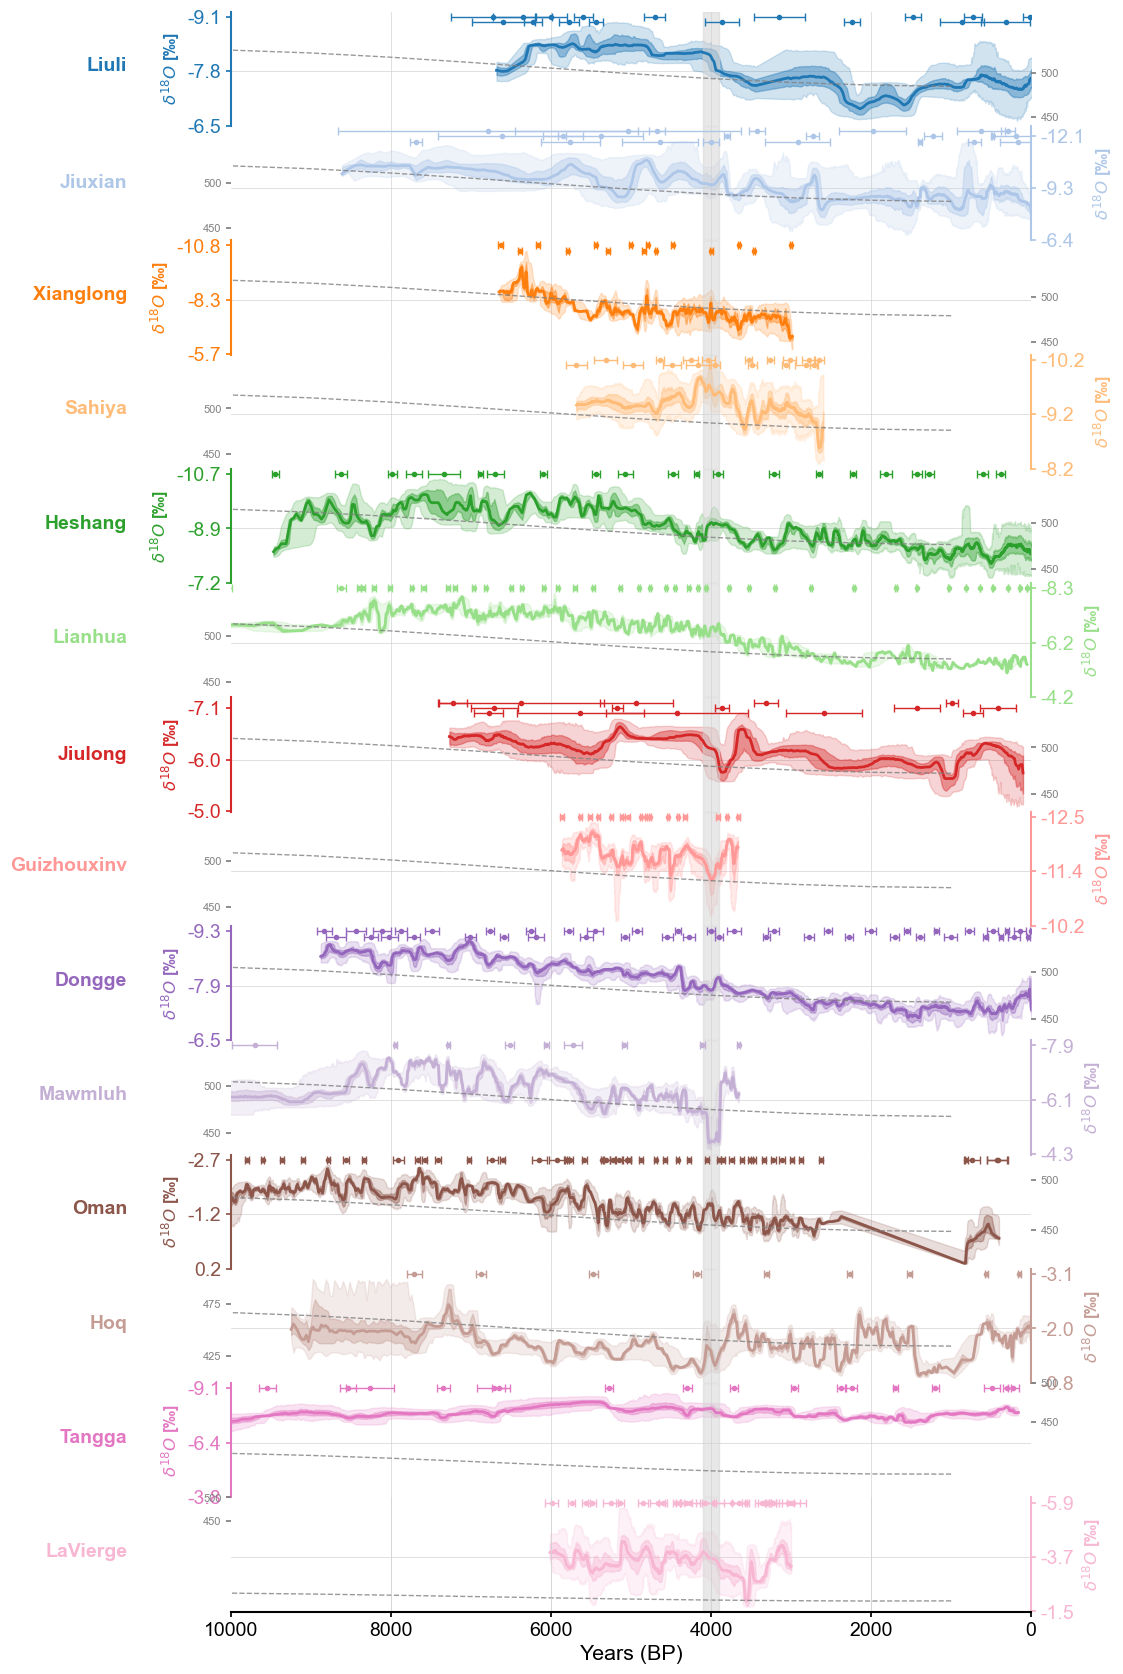

In [7]:
# Create a figure with a specified size
fig = plt.figure(figsize=(8, 16))

# Set up plot parameters
xlim = [0, 10000]
n_ts = len(ens_dict)
fill_between_alpha = 0.2
cmap = 'tab20'
labels = 'auto'
ylabel_fontsize = 12
spine_lw = 1.5
grid_lw = 0.5
label_x_loc = -0.15
v_shift_factor = 1
linewidth = 1.5

ax = {}
left = 0
width = 1
height = 1 / n_ts
bottom = 1

# Create a color palette with the same number of colors as the length of ens_dict
colors = sns.color_palette('tab20', n_colors=len(ens_dict))

# Iterate over each pair in ens_dict
for idx, pair in enumerate(ens_dict.items()):
    color = colors[idx]
    label, ens = pair
    bottom -= height * v_shift_factor
    ax[idx] = fig.add_axes([left, bottom, width, height])
    
    # Plot the ensemble envelope
    ens.common_time(time_axis=series_dict[label].time, bounds_error=False).plot_envelope(ax=ax[idx], shade_clr=color, curve_clr=color)
    
    # Create a twin y-axis
    ax2 = ax[idx].twinx()
    ax2.grid(False)
    
    # Plot the insolation data on the twin y-axis
    inso_dict[label].plot(ax=ax2, color='grey', alpha=.8, linestyle='--', linewidth=1, ylabel='')
    
    # Set plot properties for the main axis
    ax[idx].patch.set_alpha(0)
    ax[idx].set_xlim(xlim)
    time_label = 'Years (BP)'
    value_label = '$\delta^{18} O$ [‰]'
    ax[idx].set_ylabel(value_label, weight='bold', size=ylabel_fontsize)
    
    # Add labels to the plot
    ylim = ax[idx].get_ylim()
    trans = transforms.blended_transform_factory(ax[idx].transAxes, ax[idx].transData)
    ax[idx].text(-.13, np.mean(ylim), label, horizontalalignment='right', transform=trans, color=color, weight='bold')
    ax[idx].set_yticks([ylim[0], np.mean(ylim), ylim[-1]])
    ax[idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[idx].grid(False)
    
    # Set spine and tick properties based on index
    if idx % 2 == 0:
        ax[idx].spines['left'].set_visible(True)
        ax[idx].spines['left'].set_linewidth(spine_lw)
        ax[idx].spines['left'].set_color(color)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].yaxis.set_label_position('left')
        ax[idx].yaxis.tick_left()
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.yaxis.set_label_position('right')
        ax2.yaxis.tick_right()
    else:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(True)
        ax[idx].spines['right'].set_linewidth(spine_lw)
        ax[idx].spines['right'].set_color(color)
        ax[idx].yaxis.set_label_position('right')
        ax[idx].yaxis.tick_right()
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.yaxis.set_label_position('left')
        ax2.yaxis.tick_left()
    
    # Add error bars to the plot based on the label
    ylim_mag = max(ylim) - min(ylim)
    offset = ylim_mag * .05
    if label in ['Xianglong', 'Dongge', 'Sahiya', 'Liuli']:
        ax[idx].errorbar(holo_chrons[label]['dating_age'][0::2], [ylim[0]] * len(holo_chrons[label]['dating_age'][0::2]), xerr=holo_chrons[label]['dating_error'][0::2], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][1::2], [ylim[0] + offset] * len(holo_chrons[label]['dating_age'][1::2]), xerr=holo_chrons[label]['dating_error'][1::2], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    elif label in ['Jiuxian', 'Jiulong']:
        ax[idx].errorbar(holo_chrons[label]['dating_age'][0::3], [ylim[0]] * len(holo_chrons[label]['dating_age'][0::3]), xerr=holo_chrons[label]['dating_error'][0::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][1::3], [ylim[0] + offset] * len(holo_chrons[label]['dating_age'][1::3]), xerr=holo_chrons[label]['dating_error'][1::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][2::3], [ylim[0] - offset] * len(holo_chrons[label]['dating_age'][2::3]), xerr=holo_chrons[label]['dating_error'][2::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    else:
        ax[idx].errorbar(holo_chrons[label]['dating_age'], [ylim[0]] * len(holo_chrons[label]['dating_age']), xerr=holo_chrons[label]['dating_error'], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    
    # Set additional plot properties
    ax[idx].yaxis.label.set_color(color)
    ax[idx].tick_params(axis='y', colors=color)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].tick_params(axis='x', which='both', length=0)
    ax[idx].set_xlabel('')
    ax[idx].set_xticklabels([])
    ax[idx].legend([])
    xt = ax[idx].get_xticks()[1:-1]
    for x in xt:
        ax[idx].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].axhline(y=np.mean(ylim), color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].invert_xaxis()
    ax[idx].invert_yaxis()
    ax[idx].axvspan(4100, 3900, color='lightgrey', alpha=0.5)
    
    # Set properties for the twin y-axis
    ax2.tick_params(axis='y', colors='grey', labelsize=8)
    if label in ['Hoq']:
        yticks2 = [425, 475]
    else:
        yticks2 = [450, 500]
    ax2.set_yticks(yticks2)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.tick_params(axis='x', which='both', length=0)
    ax2.set_xlabel('')
    ax2.set_xticklabels([])
    ax2.legend([])

# Set up the x-axis label at the bottom
bottom -= height * (1 - v_shift_factor)
ax[n_ts] = fig.add_axes([left, bottom, width, height])
ax[n_ts].set_xlabel(time_label)
ax[n_ts].spines['left'].set_visible(False)
ax[n_ts].spines['right'].set_visible(False)
ax[n_ts].spines['bottom'].set_visible(True)
ax[n_ts].spines['bottom'].set_linewidth(spine_lw)
ax[n_ts].set_yticks([])
ax[n_ts].patch.set_alpha(0)
ax[n_ts].set_xlim(xlim)
ax[n_ts].grid(False)
ax[n_ts].tick_params(axis='x', which='both', length=3.5)
xt = ax[n_ts].get_xticks()[1:-1]
for x in xt:
    ax[n_ts].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
ax[n_ts].invert_xaxis()
ax[n_ts].invert_yaxis()

In [8]:
pyleo.savefig(fig,'../figures/ensemble_inso.pdf')

Figure saved at: "../../figures/ensemble_inso.pdf"
